In [ ]:
# Import libraries
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random

In [ ]:
# Creating pairs of images
def create_pairs(x, digit_indices):
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    for d in range(10):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    
    digit_indices = [np.where(labels == i)[0] for i in range(10)]
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    
    return pairs, y


def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [ ]:
# Import the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

train_images = train_images / 255.0
test_images = test_images / 255.0

tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

4423680/4422102 [==============================] - 0s 0us/step


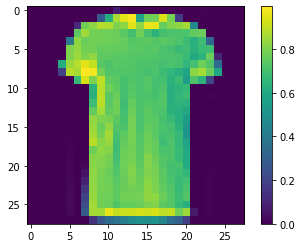

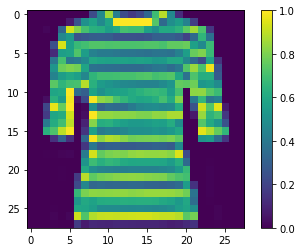

1.0


In [ ]:
this_pair = 8

show_image(tr_pairs[this_pair][0])
show_image(tr_pairs[this_pair][1])

print(tr_y[this_pair])

In [ ]:
# Custom neural network
def initialize_base_network():
    input = Input(shape=(28,28,), name="base_input")
    x = Flatten(name="flatten_input")(input)
    x = Dense(128, activation='relu', name="first_base_dense")(x)
    x = Dropout(0.1, name="first_dropout")(x)
    x = Dense(128, activation='relu', name="second_base_dense")(x)
    x = Dropout(0.1, name="second_dropout")(x)
    x = Dense(128, activation='relu', name="third_base_dense")(x)

    return Model(inputs=input, outputs=x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

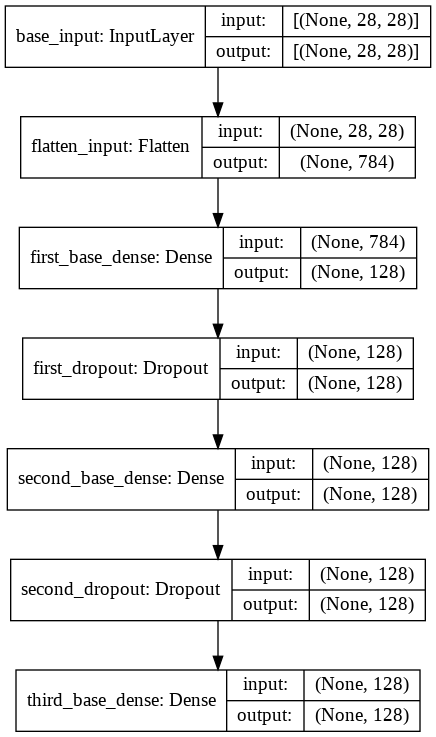

In [ ]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True)

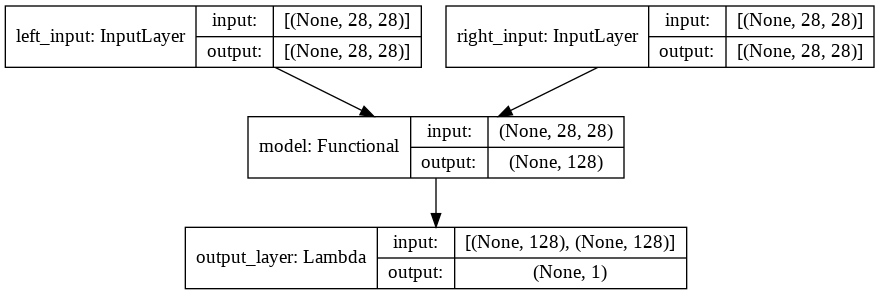

In [ ]:
input_a = Input(shape=(28,28,), name="left_input")
vect_output_a = base_network(input_a)

input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

output = Lambda(euclidean_distance, name="output_layer", output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])

model = Model([input_a, input_b], output)

plot_model(model, show_shapes=True, show_layer_names=True, to_file='outer-model.png')

In [ ]:
# Custom loss function
from tensorflow.keras.losses import Loss
class ContrastiveLoss(Loss):

  margin = 0
  
  def __init__(self,margin):
    super().__init__()
    self.margin = margin

  def call(self,y_true,y_pred):
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(self.margin - y_pred,0))
    return K.mean(y_true*square_pred + (1-y_true)*margin_square)

In [ ]:
# Training our model
adam = Adam()
model.compile(loss=ContrastiveLoss(margin=1), optimizer=adam,metrics=['accuracy'])
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=100, batch_size=128, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

In [55]:
y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])

In [56]:
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')

def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') 
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

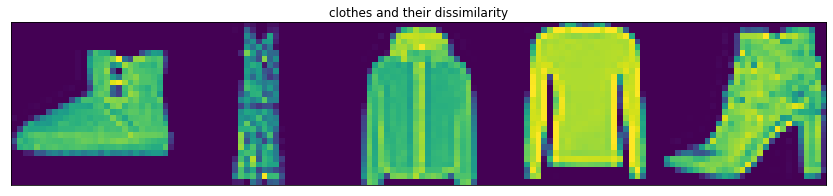

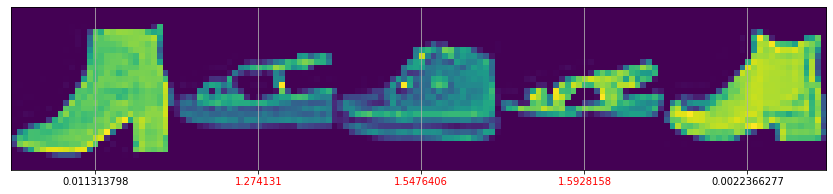

In [58]:
y_pred_train = np.squeeze(y_pred_train)
indexes = np.random.choice(len(y_pred_train), size=5)
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 5)